In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import os
import torch
from PIL import Image  
from skimage.transform import resize
from transformation_3d import *


In [2]:
dataframe = pd.read_csv("../ADNI/B1_correction_new.csv") # 記錄每張MRI影像的metadata
img_data = os.listdir("../../../mnt/usb/kuopc/ADNI_B1/MPR__GradWarp__B1_Correction/")# 這邊的img是已經將mask與MRI做結合的圖片
img_data_mask = os.listdir("../../../mnt/usb/kuopc/ADNI_B1/MPR__GradWarp__B1_Correction__Mask/")# 這邊的img是已經將mask與MRI做結合的圖片



In [3]:
def find_mask_idx(ID):
    for i, j in enumerate(img_data_mask):
        img_ID = j[j.rindex('_S')+1:j.rindex('_I')]
        if (img_ID == ID):
            return i

In [ ]:
count = 0

np.random.seed(2021)

for i, data in enumerate(img_data):
        
    img_filename = data
    img_ID = img_filename[img_filename.rindex('_S')+1:img_filename.rindex('_I')]
    
    mask_idx = find_mask_idx(img_ID)
    
    mask_filename = img_data_mask[mask_idx]
    img_ID_mask = mask_filename[mask_filename.rindex('_S')+1:mask_filename.rindex('_I')]
    
    sitk_img = sitk.ReadImage('../../../mnt/usb/kuopc/ADNI_B1/MPR__GradWarp__B1_Correction/' + img_filename)
    img = sitk.GetArrayFromImage(sitk_img)

    sitk_mask = sitk.ReadImage('../../../mnt/usb/kuopc/ADNI_B1/MPR__GradWarp__B1_Correction__Mask/' + mask_filename)
    resampled_mask_img = sitk.GetArrayFromImage(sitk.Resample(sitk_mask, sitk_img, sitk.Transform(), sitk.sitkNearestNeighbor, 0, sitk_mask.GetPixelID()))
            
    img = mask_img(img, resampled_mask_img)
    
    img = np.flip(np.moveaxis(img, [0, 1, 2], [2, 1, 0]), axis=1)

    image = crop(img)

    image = torch.from_numpy(image)
    
    image_crop = resize(image, (256, 256, 256))
    
    path = "../../../mnt/usb/kuopc/ADNI_B1/MPR__GradWarp__B1_Correction_crop/" + img_filename  
    
    image_crop_saved = nib.Nifti1Image(image_crop, np.eye(4))
    nib.save(image_crop_saved, path) #save new image     

In [ ]:
np.random.seed(2021)

img_data = os.listdir("../../../mnt/usb/kuopc/ADNI_B1/MPR__GradWarp__B1_Correction_crop/")# 這邊的img是已經將mask與MRI做結合的圖片

for i, img_filename in enumerate(img_data):
            
    image_crop = load_img("../../../mnt/usb/kuopc/ADNI_B1/MPR__GradWarp__B1_Correction_crop/" + img_filename) 
    
    rand = np.random.randint(0, 4, 1)
    
    image_aug = transformation(image_crop, rand)
    
    path = "../../../mnt/usb/kuopc/ADNI_B1/MPR__GradWarp__B1_Correction_aug/" + img_filename 
    
    image_aug = resize(image_aug, (256, 256, 256))

    image_aug_saved = nib.Nifti1Image(image_aug, np.eye(4))
    nib.save(image_aug_saved, path) #save new image


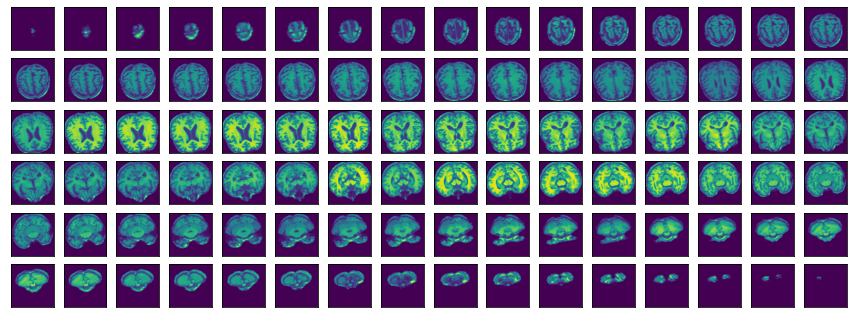

In [27]:
image_aug = resize(image_aug, (96, 96, 96))

for i in range(image_aug.shape[0]):
    plt.subplot(16, 16, i+1)
    fig = plt.imshow(image_aug[i, :, :])

    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

    plt.gcf().set_size_inches(15,15)
plt.show()

In [12]:
from sklearn.model_selection import train_test_split

train_list, test_list = train_test_split(np.unique(dataframe['Subject'].values), test_size=0.2, random_state=2021)
train_list, test_list = train_test_split(train_list, test_size=0.2, random_state=2021)

In [ ]:
df = pd.DataFrame(columns=['ImageID', 'SubjectID', 'Group', 'Sex', 'Age', 'Race', 'Split', 'Filename'])
count = 0
for i in img_data:
    subject_ID = i[5:15]
    a = i[:-4]
    img_ID = a[a.rindex('_')+1:]
    
    temp_df = dataframe.loc[dataframe['Subject'] == subject_ID]
    
    if (temp_df.empty):
        continue
    else:
        race = get_race(subject_ID)
        img_df = temp_df.loc[temp_df['Image Data ID']==img_ID]
        if (subject_ID in train_list):
            split = 'train'
        elif (subject_ID in test_list):
            split = 'test'
        elif (subject_ID in val_list):
            split = 'val'
        else:
            continue
            
        if (img_df.empty):
            group = temp_df['Group'].values[0]
            sex = temp_df['Sex'].values[0]
            age = np.mean(temp_df['Age'].values)
        else:
            group = img_df['Group'].values[0]
            sex = img_df['Sex'].values[0]
            age = img_df['Age'].values[0]
            
        filename = "../../../mnt/usb/kuopc/ADNI_B1/MPR__GradWarp__B1_Correction_crop/" + i
        single_df = pd.DataFrame({'ImageID':img_ID, 'SubjectID':subject_ID, 'Group':group, 'Sex':sex, 'Age':age, 'Split':split, 'Filename':filename}, index=[count])
        df = df.append(single_df)
        count += 1
        
df.to_csv('data_new.csv')

In [ ]:
g_ = df.groupby(['Age', 'Sex'])
df_ = g_.apply(lambda x: x.sample(g_.size().min())).reset_index(level=[0, 1, 2], drop=True)

df_.to_csv('data_balanced.csv')